In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
import plotly.express as px
import scipy
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(style='whitegrid') 
fig_DIR = "../figs/team_leaders/"
box_DIR = "./boxscores/"

In [2]:
from plotnine import ggplot,aes,ggsave,themes,theme
from plotnine import geom_point, geom_line,geom_smooth,geom_hline,facet_wrap,geom_boxplot,geom_violin,geom_density
from plotnine import labs,element_rect,element_blank,element_text
from plotnine import scale_color_manual,scale_y_continuous, ylim, scale_x_date,scale_color_identity
theme_sra = themes.theme_538(base_size=9, base_family="Tahoma")
theme_sra += theme(
                    # plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"),
                    plot_title = element_text(face = 'bold',size=16),
                    strip_text = element_text(face = 'bold',size=10),
                    plot_caption = element_text(size=10),
                    plot_subtitle = element_text(size=12),
                    axis_text_x = element_text(size=8),
                    axis_text_y = element_text(size=8),
                    axis_title_x = element_text(size=12),
                    axis_title_y = element_text(size=12)
                ) 

In [29]:
def rolling_val(df,val):
    df["r"+val] = df.apply(lambda x: x[val]*x["poss"],axis=1).cumsum()/df["tposs"]
    return df

In [31]:
def get_rolling_ratings(season = 2023, remove_games_start = 0, remove_games_end = 0):
    df1 = pd.read_csv(box_DIR + f"NBA_BoxScores_Adv_{season}.csv")
    df1 = df1.rename(columns = {"offensiveRating":"ORtg","defensiveRating":"DRtg","netRating":"NRtg","possessions":"poss"})
    cols = ["gameId","teamId","ORtg","DRtg","NRtg","poss"]
    df1 = df1[cols]
    df1["Win"]  = df1["NRtg"] >0
    df1["Loss"]  = df1["NRtg"] <0
    df2 = pd.read_csv(box_DIR + f"NBA_BoxScores_Standard_{season}.csv")
    df2 = df2.rename(columns={"GAME_ID":"gameId","TEAM_ID":"teamId","TEAM_ABBREVIATION":"teamTricode","GAME_DATE":"gameDate","TEAM_NAME":"teamName"})
    cols2 = ["gameId","teamId","teamTricode","gameDate"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    df33 = pd.read_csv(box_DIR + f"NBA_BoxScores_4Factor_{season}.csv")
    df33 = df33.rename(columns={"effectiveFieldGoalPercentage":"eFG1","freeThrowAttemptRate":"FTA1","teamTurnoverPercentage":"TOV1","offensiveReboundPercentage":"OREB1","oppEffectiveFieldGoalPercentage":"eFG2","oppFreeThrowAttemptRate":"FTA2","oppTeamTurnoverPercentage":"TOV2","oppOffensiveReboundPercentage":"OREB2"})
    cols3 = ["gameId","teamId","eFG1","FTA1","TOV1","OREB1","eFG2","FTA2","TOV2","OREB2"]
    df33 = df33[cols3]
    df32 = pd.merge(df2,df1,on=["gameId","teamId"])
    df3 = pd.merge(df32,df33,on=["gameId","teamId"])
    df4 = df3.sort_values(by=["teamTricode","gameDate"]).reset_index(drop=True)
    df6 = df3.sort_values(by=["gameDate"]).reset_index(drop=True)
    teams = df6["teamTricode"].unique()

    dfa = []
    dfa2 = []
    for team in teams:
        team = teams[0]
        df5 = df4[df4["teamTricode"]==team].reset_index(drop=True)
        df5["tposs"]=df5["poss"].cumsum()
        vals = ["ORtg","DRtg","eFG1","FTA1","TOV1","OREB1","eFG2","FTA2","TOV2","OREB2"]
        for val in vals:
            df5 = rolling_val(df5,val)
        df5["rNRtg"] = df5["rORtg"] - df5["rDRtg"]
        df5["Wins"]=df5["Win"].cumsum()
        df5["Losses"]=df5["Loss"].cumsum()
        df5["Games_Played"] = df5["Wins"] + df5["Losses"]
        df5["Win_Frac"] = df5["Wins"]/df5["Games_Played"]
        df5["Rem_Wins"] = df5["Wins"].iloc[-1] - df5["Wins"]
        df5["Rem_Losses"] = df5["Losses"].iloc[-1] - df5["Losses"]
        df5["Rem_Games"] = df5["Games_Played"].iloc[-1] - df5["Games_Played"]
        df5["Rem_Win_Frac"] = df5["Rem_Wins"]/df5["Rem_Games"]
        rvals = [ "r" + val for val in vals]
        for val in rvals[2:]:
            df5[val] = df5[val].round(3)
        df5["rORtg"] = df5["rORtg"].round(2)
        df5["rDRtg"] = df5["rDRtg"].round(2)
        df5["rNRtg"] = df5["rNRtg"].round(2)
        df5["Win_Frac"] = df5["Win_Frac"].round(4)
        df5["Rem_Win_Frac"] = df5["Rem_Win_Frac"].round(4)
        df5["Win_Percent"]  = 100*df5["Win_Frac"]
        df5["Rem_Win_Percent"]  = 100*df5["Rem_Win_Frac"]
        df7 = df5.tail(1)
        # df5 = df5[(df5["Games_Played"]>min_games) ].reset_index(drop=True)
        if remove_games_start > 0:
            df5 = df5.iloc[remove_games_start:]
        if remove_games_end > 0:
            df5 = df5.iloc[:-remove_games_end]
        df5 = df5.reset_index(drop=True)
        dfa.append(df5)
        dfa2.append(df7)
    data = pd.concat(dfa)
    dataf = pd.concat(dfa2)
    data["Team"] = data["teamTricode"]
    dataf["Team"] = dataf["teamTricode"]
    data = data.rename(columns={"gameDate":"Date"})
    dataf = dataf.rename(columns={"gameDate":"Date"})

    return data,dataf

In [32]:
dfa1, dfa2 = [], []
for season in range(2010,2023):
    df1,df2 = get_rolling_ratings(season,remove_games_start=5) 
    dfa1.append(df1)
    dfa2.append(df2)
data = pd.concat(dfa1)
data = data[(data["Win_Frac"]>0) & (data["Win_Frac"]<1)].reset_index(drop=True)
datafin = pd.concat(dfa2)

In [33]:
len(datafin[datafin["rNRtg"]<0])

30

In [28]:
len(data[data["rNRtg"]>0])

24960

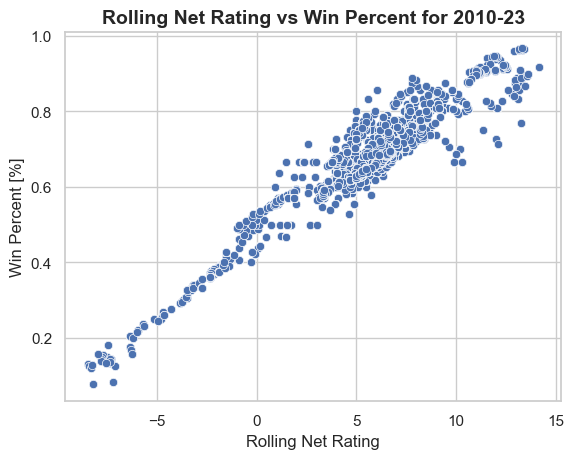

In [26]:
var1 = "rNRtg"
var2 = "Win_Percent"
var3 = "Win_Frac"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=data[var1], y=data[var3])
mfit = slope
cfit = intercept
slope0, intercept0, r0, p0, sterr0 = scipy.stats.linregress(x=datafin[var1], y=datafin[var3])
R2 = r**2
fig, ax = plt.subplots(1,1)
# ax.vlines(x=0,ymin=0,ymax=100,color="k",linestyles="--")
# ax.hlines(y=50,xmin=-15,xmax=15,color="k",linestyles="--")
# sns.regplot(x = var1, y = var2, data = data,color ="black",scatter_kws = {"color":"tab:blue"} ,ax=ax)
# sns.scatterplot(x = var1, y = var2, data = datafin, color="red", ax = ax)
sns.scatterplot(x=var1,y=var3,data= data,ax=ax)
# ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)
ax.set_title("Rolling Net Rating vs Win Percent for 2010-23",fontsize=14,fontweight="bold")
ax.set_xlabel("Rolling Net Rating")
ax.set_ylabel("Win Percent [%]")
plt.savefig("../figs/team_leaders/NET_WinLoss_R2.png")
plt.show()

In [8]:

data["Win_Frac_Pred"] =  cfit + mfit * data["rNRtg"]
data["Wins_Pred"] = data["Win_Frac_Pred"] * data["Games_Played"]
data["Wins_Pred"] = data["Wins_Pred"].round().astype(int)
data["Losses_Pred"] = data["Games_Played"] - data["Wins_Pred"]

In [9]:
datafin["Win_Frac_Pred"] =  cfit + mfit * datafin["rNRtg"]
datafin["Wins_Pred"] = datafin["Win_Frac_Pred"] * datafin["Games_Played"]
datafin["Wins_Pred"] = datafin["Wins_Pred"].round().astype(int)
datafin["Losses_Pred"] = datafin["Games_Played"] - datafin["Wins_Pred"]

In [ ]:
# dataf[["Games_Played","rNRtg","Wins","Wins_Pred","Losses","Losses_Pred"]]

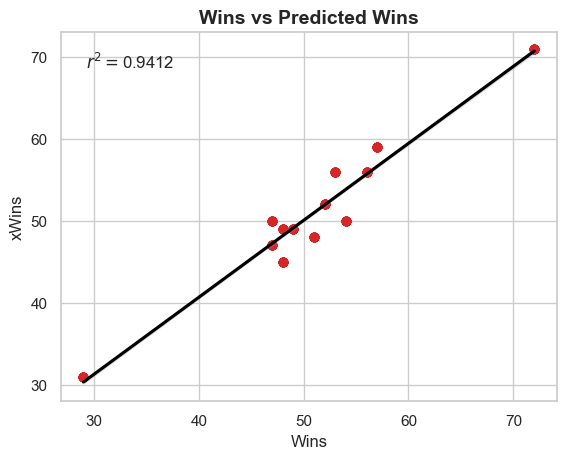

In [10]:
fig, ax = plt.subplots(1,1)
var1 = "Wins"
var2 = "Wins_Pred"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=datafin[var1], y=datafin[var2])
R2 = r**2
sns.regplot(x = var1, y = var2, data = datafin,color ="black",scatter_kws = {"color":"tab:red"} ,ax=ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)
ax.set_title("Wins vs Predicted Wins",fontsize=14,fontweight="bold")
ax.set_xlabel("Wins")
ax.set_ylabel("xWins")
plt.savefig("../figs/team_leaders/simple_win_model.png")
plt.show()

In [ ]:
season = "2023"
dfc,dfcf = get_rolling_ratings(season,min_games = 5) 
dfcf["Win_Frac_Pred"] =  cfit + mfit * dfcf["rNRtg"]
dfcf["Wins_Pred"] = dfcf["Win_Frac_Pred"] * dfcf["Games_Played"]
dfcf["Wins_Pred"] = dfcf["Wins_Pred"].round().astype(int)
dfcf["Losses_Pred"] = dfcf["Games_Played"] - dfcf["Wins_Pred"]

In [ ]:
# dfcf[["Games_Played","rNRtg","Wins","Wins_Pred","Losses","Losses_Pred"]]

In [ ]:
import seaborn.objects as snso

In [ ]:
dfcf = dfcf.reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(1,1)
var1 = "Wins"
var2 = "Wins_Pred"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=dfcf[var1], y=dfcf[var2])
R2 = r**2
sns.regplot(x = var1, y = var2, data = dfcf,color ="black",scatter_kws = {"color":"red"} ,ax=ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)
p = snso.Plot(data = dfcf,x=var1,y=var2,text="Team").add(snso.Text(valign="bottom"))
p.on(ax).show();
ax.set_title("Wins vs Predicted Wins 2023-24",fontsize=14,fontweight="bold")
ax.set_xlabel("Wins")
ax.set_ylabel("xWins")
ax.set_ylim([1,14])
fig.savefig("../figs/team_leaders/simple_win_model_2023.png")
plt.show()

## Modeling Remaining Wins

In [ ]:
dfa1, dfa2 = [], []
for season in range(2010,2023):
    df1,df2 = get_rolling_ratings(season,remove_games_start = 5,remove_games_end = 5) 
    dfa1.append(df1)
    dfa2.append(df2)
data = pd.concat(dfa1)
data = data.dropna()
data = data[(data["Rem_Win_Frac"]>0) & (data["Rem_Win_Frac"]<1)].reset_index(drop=True)
datafin = pd.concat(dfa2)

In [ ]:
len(data)

In [ ]:
data.columns

In [ ]:
var1 = "rNRtg"
var2 = "Rem_Win_Percent"
var3 = "Rem_Win_Frac"
slope, intercept, r, p, sterr = scipy.stats.linregress(x=data[var1], y=data[var3])
mfit = slope
cfit = intercept
slope0, intercept0, r0, p0, sterr0 = scipy.stats.linregress(x=datafin[var1], y=datafin[var3])
R2 = r**2
fig, ax = plt.subplots(1,1)
ax.vlines(x=0,ymin=0,ymax=100,color="k",linestyles="--")
ax.hlines(y=50,xmin=-15,xmax=15,color="k",linestyles="--")
sns.regplot(x = var1, y = var2, data = data,color ="black",scatter_kws = {"color":"tab:blue"} ,ax=ax)
sns.scatterplot(x = var1, y = var2, data = datafin, color="red", ax = ax)
ax.text(0.05,0.90,r"$r^2=$"+f"{round(R2,4)}",transform = ax.transAxes)

ax.set_title("Rolling Net Rating vs Remaining Win Percent for 2010-23",fontsize=14,fontweight="bold")
ax.set_xlabel("Rolling Net Rating")
ax.set_ylabel("Remaining Win Percent [%]")
plt.savefig("../figs/team_leaders/NET_Rem_WinLoss_R2.png",dpi=300)
plt.show()

In [ ]:
asdsad

In [ ]:
dfa1, dfa2 = [], []
for season in range(2010,2023):
    df1,df2 = get_rolling_ratings(season,remove_games_start = 0,remove_games_end = 0) 
    dfa1.append(df1)
    dfa2.append(df2)
data = pd.concat(dfa1)
data = data.dropna()
# data = data[(data["Rem_Win_Frac"]>0) & (data["Rem_Win_Frac"]<1)].reset_index(drop=True)
datafin = pd.concat(dfa2)

In [ ]:
X_t = data_t[['eFG1', 'TOV1', 'OREB1', 'FTA1', 'eFG2',
       'TOV2', 'OREB2', 'FTA2']].to_numpy()

y_t = data_t["NRtg"].to_numpy()


In [ ]:
reg = LinearRegression(fit_intercept=False)
# reg = RidgeCV(alphas=alphas, cv=10, fit_intercept=False)
model = reg.fit(X_t,y_t)
y_pf = reg.predict(X_p)
coef = model.coef_ 
print(model.coef_)
# print(model.alpha_)